# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 24 марта 18:00 Сдача **очная** на занятии. <br\>


Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Здравствуйте, уважаемые студенты! 

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

# Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.



Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для линейной регрессии.
* Выпишите формулу обновления весов для линейной регрессии с L2 регуляризацией для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент?

***Ваше решение здесь***

Формула для градиентного спуска (обычного, пакетного, случайного) выглядит так
$$ 
w_{new} = w_{old} - h \nabla_w Q(x,w_{old}),
$$
где $h$ - темп обучения, а $Q(x,w)$ - функционал качества. Разница в "спусках" только в данных, которые мы подставляем в функционал.

Значит нужно найти градиент функционала качества: 
$$
\nabla_w Q(x,w) = \nabla_w ( \frac{1}{n}||Xw - y||^2 + w^T\lambda Iw),
$$
где $n$ - размер подвыборки, по которой мы делаем шаг спуска, $\lambda$ - параметр регуляризации.

Считаем:
$$
\nabla_w (w^T\lambda Iw) = 2\lambda Iw
$$
$$
\nabla_w (\frac{1}{n}||Xw - y||^2) =   \nabla_w (\frac{1}{n} (w^T X^T Xw - w^T X^T y - y^T Xw + y^Ty)) =  \frac{2}{n} (X^TXw - X^Ty) 
$$
Таким образом, 
$$
\nabla_w Q(x,w)  =  \frac{2}{n} (X^TXw - X^Ty) + 2\lambda Iw = 2((\frac{1}{n} X^TX +  \lambda I)w - \frac{1}{n}X^Ty)
$$

Искомая формула пересчёта весов для линейной регрессии с L2 регуляризацией для мини-батч градиентого спуска размера $n$:

$$ w_{new} =  w_{old} - 2h((\frac{1}{n} X^TX +  \lambda I)w_{old} - \frac{1}{n}X^Ty) $$

Заметим, что размерность $X$ - $(n,D)$, $y$ - $(n,1)$.

***Конец решения***

Задача 2. Градиент для логистической регрессии.
* Выпишите формулу обновления весов для логистической регрессии с L2 регуляризацией  для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент? Как соотносится этот градиент с градиентом, возникающий в задаче линейной регрессии?

Подсказка: Вам градиент, которой получается если “в лоб” продифференцировать,  надо немного преобразовать.
Надо подставить, что $1 - \sigma(w,x) $ это  $1 - a(x_i)$, а  $-\sigma(w,x)$ это $0 - a(x_i)$.  Тогда получится свести к одной красивой формуле с линейной регрессией, которую программировать будет намного проще.

***Ваше решение здесь***

Опять ищем градиент для функционала качества.
$$ 
\nabla_w Q(w) = \nabla_w \left( -\frac{1}{n}\left[\sum_i y_i \log a_i  + ( 1 - y_i) \log (1 - a_i) \right] + w^T\lambda Iw\right),
$$
где $n$ - размер подвыборки для шага. 

Легко видеть, что 
$$
\nabla_w (w^T\lambda Iw)  = 2\lambda Iw
$$
Перед подсчётом градиента первого слагаемого найдём
$$ 
\nabla_w a_i  = \nabla_w \left(\frac{1}{1 + \exp(-\left< x_i,w\right>)}\right)  =  \frac{ x_i \exp(-\left< x_i,w\right> )}{(1 + \exp(-\left< x_i,w\right>))^2}  = \sigma(\left< x_i,w\right>)^2 x_i \exp(-\left<x_i,w\right>).
$$
Ищем вектор частных производных LogLoss функции на одном слагаемом.
\begin{multline*}
\nabla_w L(w) = \\
\nabla_w (y_i \log a_i  + ( 1 - y_i) \log (1 - a_i)) =  -\left(y_i \frac{a_i^2 x_i \exp(-\left<x_i,w\right>)}{a_i} - (1 - y_i) \frac{ a_i^2 x_i \exp(-\left<x_i,w\right>)}{1 - a_i}\right) = \\
 -a_i^2 x_i \exp(-\left< x_i,w\right>) \left(\frac{-y_i}{ - a_i} - \frac{1 - y_i}{1 - a_i}\right) =  -a_i^2 x_i \exp(-\langle\,x_i,w\rangle) \frac{a_i - y_i}{ - a_i(1 - a_i)} = \\
\frac {a_i x_i \exp(-\langle\,x_i,w\rangle) (a_i - y_i)}{1 - a_i} = x_i  (a_i - y_i)
\end{multline*}
Последнее равенство верно, так как $a_i \exp(-\langle\,x_i,w\rangle)=1-a_i$.

Таким образом, 
$$
\nabla_w Q(x,w) =  \frac{1}{n}X^T(a - y) +  2\lambda Iw,
$$
где $a=(a_1,...,a_l),\,y=(y_1,...,y_l)$, $x_i$ - строки матрицы $X$.

Итог:

$$ w_{new} = w_{old} - h\left(\frac{1}{n}X^T(a_{old}-y) - 2\lambda Iw_{old} \right) $$

***Конец решения***

Задача 3. Точное решение линейной регрессии

На лекции было показано, что точное решение линейной регрессии имеет вид $w = (X^TX)^{-1}X^TY $. 
* Покажите, что это действительно является точкой минимума в случае, если матрица X имеет строк не меньше, чем столбцов и имеет полный ранг. Подсказка: посчитайте Гессиан и покажите, что в этом случае он положительно определен. 
* Выпишите точное решение для модели с $L2$ регуляризацией. Как L2 регуляризация помогает с точным решением где матрица X имеет линейно зависимые признаки?

***Ваше решение здесь***

1) Для того, чтобы получить Гессиан, продифференцируем выражение из первой задачи (слагаемое без регуляризации).

$$  \nabla_w \nabla_w (Q(x,w))  = \nabla_w \frac{2}{n}(X^TXw - X^Ty) = \frac{2}{n}X^TX $$

Проверим полож.опр-ность, хотим: для всех $p$ верно $p^T X^TX p \geq 0$, причём $=$ т.и т.т, к. $p=0$.

Произведение $X^TX$ можно записать как:
$$S = X^TX = \sum_{i=1}^{N}x^T_ix_i, $$
где $x_i$ - строки матрицы X с длиной D, равной числу признаков.

Каждое слагаемое $S_i = x^T_ix_i$ - это матрица размера $(D,D)$. Возьмем произвольный $p$, тогда:

$p^TS_ip = p^Tx^T_ix_ip=\left< p,x_i \right>^2$ - квадрат скалярного произведения. Таким образом $p^TS_ip \geq 0$,  а равенство 0 достигается, если $p$ ортогонален $x_i$. 

Тогда сумма может обратиться в ноль, только если $p$ ортогонален всем $x_i$.

То есть, если найдётся $D$ линейно независимых векторов-признаков $x_i$, то матрица положительно опр-на (в противном случае неотрицательно опр-на); так как в пространстве размерности $D$ не останется линейно незав. векторов с системой векторов-признаков.

Таким образом, при достаточном количестве разнородных данных минимум найдётся.

2) Воспользуемся началом решения задачи 1 и выпишем градиент функционала качества с L2 регуляризацией:


$$  \nabla_w Q(x,w) = \nabla_w ( \frac{1}{N}||Xw - y||^2 + w^T\lambda Iw) = 2((X^TX +  \lambda I)w - X^Ty) = 0 $$

Тогда

$$ w = (X^TX + \lambda I)^{-1}X^Ty $$

***Прибавление*** $\lambda I$ к $X^TX$, то есть прибавление числа $\lambda$ к каждому диагональному элементу $X^TX$, ***обеспечивает обратимость*** $(X^TX + \lambda I)$, начиная с некоторого достаточно большого $\lambda$.

***Конец решения***

Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

***Ваше решение здесь***

Обозначим $ p_i = p(y_i = 1 |x_i ) $, тогда $ p(y_i = 0 | x_i) = 1 - p_i$

Mат. ожидание $L$ при условии конкретного $x_i$ дано выше. Чтобы найти оптимальное a(x_i), возьмем производную мат. ожидания по a(x_i).

\begin{multline*}
(E(L | x_i))^{'}  = \frac{-p_i a^{'}(x_i)}{a(x_i)} + \frac{(1 - p_i)a^{'}(x_i)}{1 - a(x_i)} = a^{'}(x_i) (\frac{1-p_i}{1 - a(x_i)} - \frac{p_i}{a(x_i)}) = \\
a^{'}(x_i) \frac{a(x_i) - p_ia(x_i) - p_i + p_ia(x_i)}{a(x_i)(1 - a(x_i))} = a^{'}(x_i) \frac{a(x_i) - p_i}{a(x_i)(1 - a(x_i))} = 0
\end{multline*}

Производная среднего равнa $0$ при $a = p_i = p(y_i = 1 |x_i )$. 

***Конец решения***

Задача 5.  Смысл регуляризации.

Нужно ли в L1/L2 регуляризации использовать свободный член $w_0$ (который не умножается ни на какой признак)?

Подсказка: подумайте, для чего мы вводим $w_0$

***Ваше решение здесь***

Свободный член не нужно использовать, это в определённом смысле "среднее". Большие значения $w_0$ не влияют на смену классификации (сильное изменение значения) при подаче данных с небольшим шумом. 

***Конец решения***

#  Реализация линейной модели (4 балла)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [4]:
def fib(max_iter=5):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [5]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 4 fib values: 3


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [6]:
for i in range(0, 3):
    new_generator = fib(2)
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1


А вот так уже нельзя.

In [8]:
new_generator = fib(2)
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [10]:
import random

def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    
    ind = list(range(X.shape[0]))

    if shuffle:
        random.shuffle(ind)

    X_batch = ""
    y_batch = ""
    for i in range(0, len(ind)-batch_size+1, batch_size):
        X_batch = X[ind[i:i+batch_size]]
        y_batch = y[ind[i:i+batch_size]]
        yield (X_batch, y_batch)

# Теперь можно сделать генератор по данным ()
#  my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1):

In [224]:
#%%pycodestyle
from sklearn.base import BaseEstimator, ClassifierMixin


def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    sigm_value_x = 1/(1 + np.exp(-x))
    return sigm_value_x


class MySGDClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, batch_generator, C=1, alpha=0.01, max_epoch=10, model_type='lin_reg', 
                 batch_size=1, threshold=None):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter' : [], 'loss' : []}  
        self.model_type = model_type
        self.batch_size = batch_size
        self.threshold = threshold
        
    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        weights = self.weights
        
        #регуляризация
        C = self.C
        reg = np.square(weights)[1:].sum()/C
        
        
        if self.model_type == 'lin_reg':
            loss = (np.square(y_batch - np.dot(X_batch, weights))).sum()
            loss = loss / X_batch.shape[0] + reg
            

        elif self.model_type == 'log_reg':
            a = sigmoid(np.dot(X_batch, weights))
            num_obj = X_batch.shape[0]
            loss = (-1/num_obj) * (y_batch * np.log(a) +
                    (np.ones(num_obj)[:, np.newaxis] - y_batch) * np.log(np.ones(num_obj)[:, np.newaxis] - a)).sum() + reg
        else:
            print("Use 'lin_reg' or 'log_reg' model")
            return
        return loss

    
    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        weights = self.weights
        
        #регуляризация
        C = self.C
        reg = (2 / C) * weights[1:]
        reg = np.insert(reg,0,0)[:, np.newaxis]
        num = X_batch.shape[0]
        #print(reg.shape,'vect')
        
        if self.model_type == 'lin_reg':
            loss_grad = (2/num) * np.dot(np.transpose(X_batch),
                                         (np.dot(X_batch, weights)) - y_batch) + reg
        elif self.model_type == 'log_reg':
            a = sigmoid(np.dot(X_batch, weights))
            loss_grad = (1/num) * np.dot(np.transpose(X_batch), (a - y_batch)) + reg
        else:
            print("Use 'lin_reg' or 'log_reg' model")
            return
        #print(loss_grad.shape)
        return loss_grad
    
    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        w = self.weights
        self.weights = w - self.alpha * new_grad
    
    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        if len(y.shape) != 2:
            y = y[:, np.newaxis]
            
        if self.threshold == None:
            self.threshold=sum(y)/y.shape[0]            

        # добавляем единичный признак, чтобы было удобно считать w_0
        X = np.hstack((np.ones(X.shape[0])[:, np.newaxis], X))
        
        # Нужно инициализровать случайно веса
        self.weights = np.random.rand(X.shape[1], 1)
        steps = 0
        
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(X, y, batch_size=self.batch_size)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                # Подумайте в каком месте стоит посчитать ошибку для отладки модели
                # До градиентного шага или после
                batch_loss = self.calc_loss(X_batch, y_batch)
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
                
                '''
                print(batch_loss)
                if batch_num % N == 0 and batch_num != 0:
                    #print(self.weights)
                    #print(batch_num,
                    sum(self.errors_log['loss'][total_num - N:total_num])/N)
                    #self.alpha = self.alpha/total_num

                if total_num % 10 == 0:
                    alpha_k += 1
                    self.alpha = self.alpha/alpha_k
                    print(self.alpha)
                '''
                steps += 1

        #return self  
                
        return self
        
    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        X = np.hstack((np.ones(X.shape[0])[:, np.newaxis], X))
        
        if self.model_type == 'lin_reg':
            y_pr = np.dot(X, self.weights)
            y_hat = [y_pr > self.threshold]
            y_hat = y_hat[0].astype(int)

        elif self.model_type == 'log_reg':
            a = sigmoid(np.dot(X, self.weights))
            y_hat = [a > self.threshold]
            y_hat = y_hat[0].astype(int)

        else:
            print("Use 'lin_reg' or 'log_reg' model")
            return

        return y_hat

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [225]:
def plot_decision_boundary(clf, c='green'):
    #print(clf.weights)
    w = np.ravel(clf.weights)
    x = np.arange(0, 8, 0.1)
    y = (clf.threshold - w[0] - w[1] * x) / w[2]

    plt.plot(x, y, color=c)

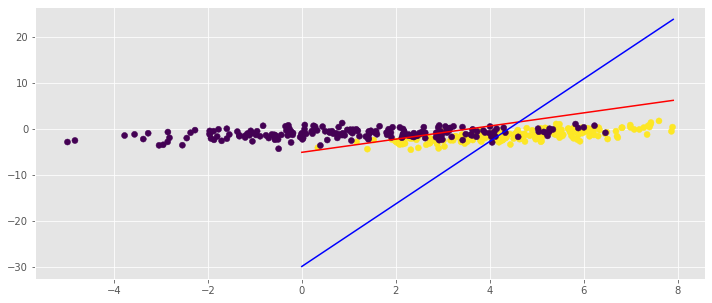

In [259]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

clf_lin = MySGDClassifier(batch_generator, model_type='lin_reg', max_epoch=100, batch_size=50)
clf_lin.fit(X, y)

clf_log = MySGDClassifier(batch_generator, model_type='log_reg', max_epoch=100, batch_size=50)
clf_log.fit(X, y)

plot_decision_boundary(clf_lin, c='red')
plot_decision_boundary(clf_log, c='blue')

plt.scatter(X[:,0], X[:,1], c=y)

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [260]:
from sklearn.datasets import make_classification

In [261]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

In [262]:
X.shape[0]

100000

Сначала выведем хоть какой-нибудь график c усреднёнными потерями. Шаг буду строить по 1000 наблюдений, чтобы точек было меньше, но уж хотя бы 10 раз по массиву пробежаться разумно. Итого 10*(100000/1000)=1000 элементов в errors_log.

In [263]:
N=10

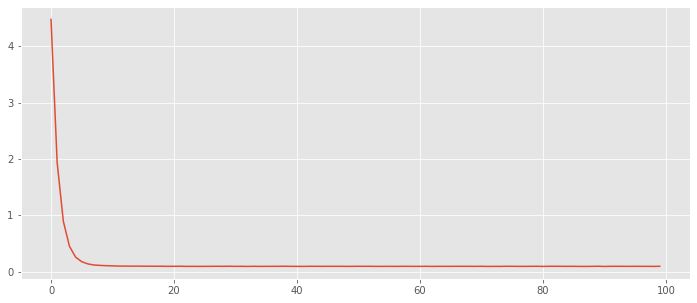

In [264]:
clf_lin = MySGDClassifier(batch_generator, model_type='lin_reg', max_epoch=10, batch_size=1000) 
clf_lin.fit(X, y)

mean_err = [np.mean(clf_lin.errors_log['loss'][i-N:i]) for i in range(N, len(clf_lin.errors_log['loss'])+1, N)]
plt.plot(mean_err)
#clf_lin.weights

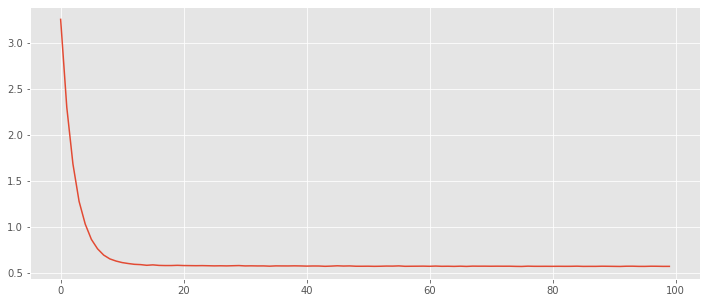

In [265]:
clf_log = MySGDClassifier(batch_generator, model_type='log_reg', max_epoch=10, batch_size=1000) 
clf_log.fit(X, y)

mean_err = [np.mean(clf_log.errors_log['loss'][i-N:i]) for i in range(N, len(clf_log.errors_log['loss'])+1, N)]
plt.plot(mean_err)
#clf_lin.weights

Теперь с подбором alpha.

In [266]:
alph=[0.1, 0.01, 0.001]
N=50

Text(0, 0.5, 'loss-function')

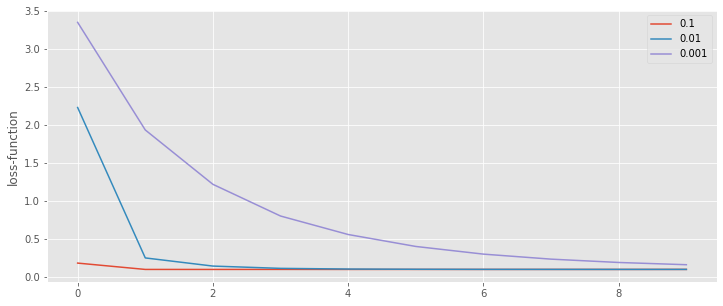

In [272]:
for j in alph:
    clf_lin = MySGDClassifier(batch_generator, model_type='lin_reg', max_epoch=5, batch_size=1000, alpha=j)
    clf_lin.fit(X, y)
    mean_err = [np.mean(clf_lin.errors_log['loss'][i-N:i]) for i in range(N, len(clf_lin.errors_log['loss'])+1, N)]
    plt.plot(mean_err, label=j)
plt.legend()
plt.ylabel('loss-function')

#clf_lin.weights

Text(0, 0.5, 'loss-function')

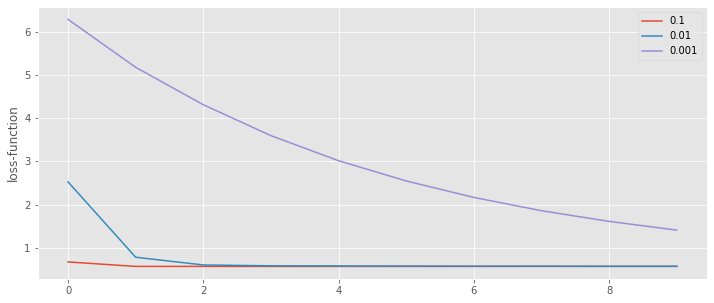

In [273]:
for j in alph:
    clf_log = MySGDClassifier(batch_generator, model_type='log_reg', max_epoch=5, batch_size=1000, alpha=j)
    clf_log.fit(X, y)
    mean_err = [np.mean(clf_log.errors_log['loss'][i-N:i]) for i in range(N, len(clf_log.errors_log['loss'])+1, N)]
    plt.plot(mean_err, label=j)
plt.legend()
plt.ylabel('loss-function')

#clf_lin.weights

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

При маленьких альфах мы медленно, но уверенно идём к правильным значениям, а при больших мы можем перескакивать минимум. Кроме того - есть риск отскачить от него далеко и сделать процесс расходящимся. Пожалуй, значение 0.01 меня устраивает.

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

Text(0, 0.5, 'loss-function')

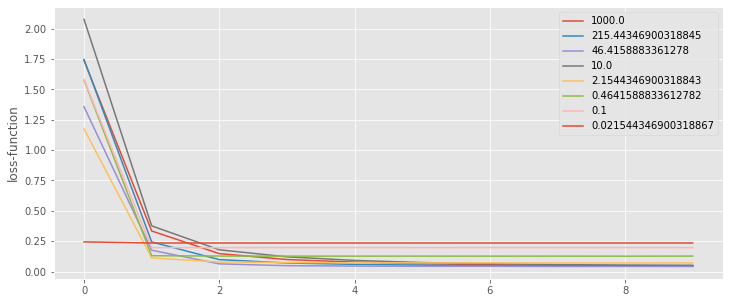

In [280]:
param=np.logspace(3, -3, 10)

for j in param[0:8]:
    clf_lin = MySGDClassifier(batch_generator, model_type='lin_reg', max_epoch=5, batch_size=1000, alpha=0.01, C=j)
    clf_lin.fit(X, y)
    mean_err = [np.mean(clf_lin.errors_log['loss'][i-N:i]) for i in range(N, len(clf_lin.errors_log['loss'])+1, N)]
    plt.plot(mean_err, label=j)
plt.legend()
plt.ylabel('loss-function')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in square
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in square
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: overflow encountered in multiply
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in subtract


Text(0, 0.5, 'loss-function')

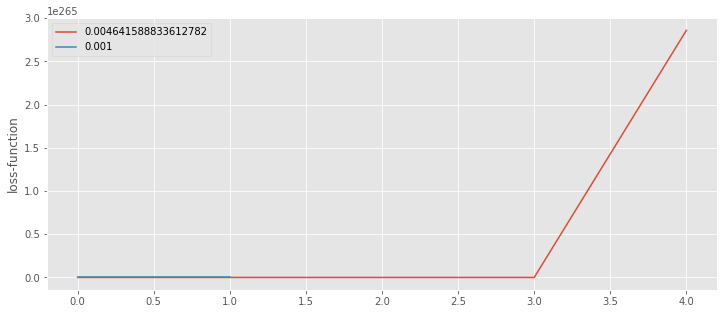

In [282]:
for j in param[8:10]:
    clf_lin = MySGDClassifier(batch_generator, model_type='lin_reg', max_epoch=5, batch_size=1000, alpha=0.01, C=j)
    clf_lin.fit(X, y)
    mean_err = [np.mean(clf_lin.errors_log['loss'][i-N:i]) for i in range(N, len(clf_lin.errors_log['loss'])+1, N)]
    plt.plot(mean_err, label=j)
plt.legend()
plt.ylabel('loss-function')

Text(0, 0.5, 'loss-function')

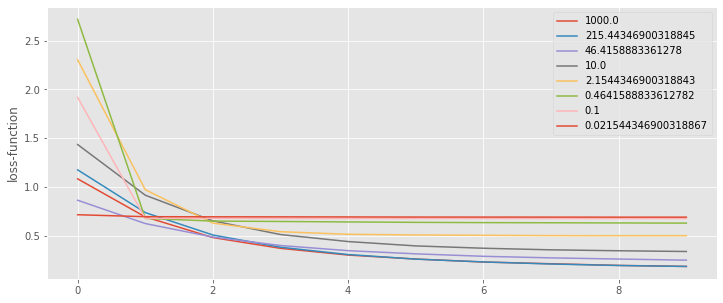

In [283]:
param=np.logspace(3, -3, 10)

for j in param[0:8]:
    clf_log = MySGDClassifier(batch_generator, model_type='log_reg', max_epoch=5, batch_size=1000, alpha=0.01, C=j)
    clf_log.fit(X, y)
    mean_err = [np.mean(clf_log.errors_log['loss'][i-N:i]) for i in range(N, len(clf_log.errors_log['loss'])+1, N)]
    plt.plot(mean_err, label=j)
plt.legend()
plt.ylabel('loss-function')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in multiply
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in square
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: overflow encountered in 

Text(0, 0.5, 'loss-function')

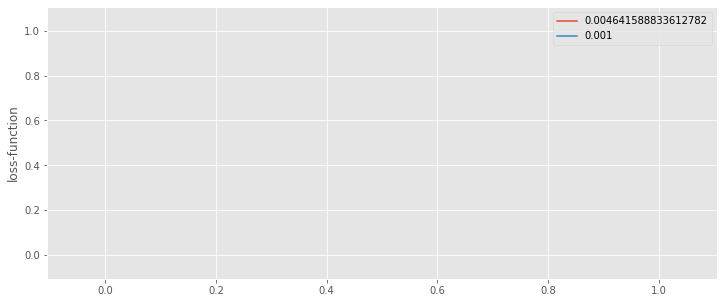

In [284]:
for j in param[8:10]:
    clf_log = MySGDClassifier(batch_generator, model_type='log_reg', max_epoch=5, batch_size=1000, alpha=0.01, C=j)
    clf_log.fit(X, y)
    mean_err = [np.mean(clf_log.errors_log['loss'][i-N:i]) for i in range(N, len(clf_log.errors_log['loss'])+1, N)]
    plt.plot(mean_err, label=j)
plt.legend()
plt.ylabel('loss-function')

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

При разумном подборе параметра ошибка действительно может стать меньше. 
Но на сверхмалых значениях алгоритм расходится. Формула обновления весов превращается во что-то подобное:
$$
w_{new}=w_{old}-\lambda w_{old} +\varepsilon,
$$
где $\lambda>2$. В итоге: неограниченный рост веса и соответственно ошибки.

# Боевое применение (4  балла)

**Защита данной части возможна только при преодолении в проекте бейзлайна Handmade baseline.**

Давайте применим модель на итоговом проекте! Датасет сделаем точно таким же образом, как было показано в project_overview.ipynb

Применим обе регрессии, подберем для них параметры и сравним качество. Может быть Вы еще одновременно с решением домашней работы подрастете на лидерборде!

In [304]:
import codecs
fileObj = codecs.open( "docs_titles.tsv", "r", "utf_8_sig" )
text = fileObj.read()
fileObj.close()
f.read()

''

In [306]:
f.read(100)

''

In [292]:
doc_to_title = {}
with open('.\docs_titles\docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print (len(doc_to_title))


UnicodeDecodeError: 'charmap' codec can't decode byte 0x98 in position 1043: character maps to <undefined>

In [5]:
import pandas as pd
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [6]:
import numpy as np
y_train = []
X_train = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_train.append(sorted(all_dist, reverse=True)[0:15]    )
X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print (X_train.shape, y_train.shape, groups_train.shape)

(11690, 15) (11690,) (11690,)


Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [10]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

Подберите порог линейной модели, по достижении которого, Вы будете относить объект к классу 1. Вспомните, какую метрику мы оптимизируем в соревновании.  Как тогда правильно подобрать порог?

С лучшими параметрами на валидации сделайте предсказание на тестовом множестве, отправьте его на проверку на платформу kaggle. Убедитесь, что Вы смогли побить public score первого бейзлайна.

** При сдаче домашки Вам необходимо кроме ссылки на ноутбук показать Ваш ник на kaggle, под которым Вы залили решение, которое побило Handmade baseline. **

# Фидбек (бесценно)

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

***Ваше ответ здесь***

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***

In [35]:
I = np.identity(1)
I[0][0] = 0
np.dot(I, np.square([1])/5).sum()

0.0

In [39]:
np.square([1])[1:].sum()/5

0.0

In [90]:
I = np.identity(2)
I[0][0] = 0
(2 / 5) * (np.dot(I, [1,3]))


array([0. , 1.2])

In [51]:
np.random.randn(200, 2)

array([[ 1.41117206,  0.78580383],
       [-0.05746952, -0.39121705],
       [ 0.94091761,  0.40520408],
       [ 0.4980524 , -0.02619224],
       [-1.68823003, -0.11246598],
       [-0.53248992,  0.64505527],
       [ 1.01184243, -0.65795104],
       [ 0.46838523,  1.735879  ],
       [-0.66771272,  1.68192174],
       [-0.85258585,  0.02295976],
       [-0.01114561,  0.0114989 ],
       [-0.83767804, -0.5911831 ],
       [-0.66772029,  0.3269626 ],
       [ 0.33003511,  2.22594433],
       [ 1.37098901, -0.50984324],
       [ 0.32486962,  0.99711798],
       [ 0.03060182, -0.06964158],
       [ 0.05157494,  0.86727663],
       [-0.84832052, -0.32566947],
       [ 0.47043314,  0.31144707],
       [ 0.23958276, -0.36980117],
       [ 0.97253579,  2.13386825],
       [ 0.40641549, -0.1931767 ],
       [ 0.75574029, -0.53913264],
       [-0.74969034,  0.03280875],
       [-2.58279663, -1.15395036],
       [-0.34796186, -1.35338886],
       [-1.0326431 , -0.43674834],
       [-1.64296529,

In [102]:
[i for i in range(50, 1000+1, 50)]

[50,
 100,
 150,
 200,
 250,
 300,
 350,
 400,
 450,
 500,
 550,
 600,
 650,
 700,
 750,
 800,
 850,
 900,
 950,
 1000]

In [217]:
np.insert([1,2,3],0,0)

array([0, 1, 2, 3])